<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
# to install sklearn: pip install -U scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
import networkx as nx
import pdb
import warnings
warnings.filterwarnings("ignore")

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#reading df
traincsv = pd.read_csv('train.csv')

In [4]:
#chacking if any null values in given graph 
traincsv[traincsv.isna().any(1)]

Empty DataFrame
Columns: [source_node, destination_node]
Index: []

In [5]:
#info of given data set
traincsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB


In [6]:
#no of duplicates
sum(traincsv.duplicated())

0

In [7]:
#removing header and saving
traincsv.to_csv('train_woheader.csv',header=False,index=False)

In [3]:
#Getting basic info from our data
g=nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


## EDA

In [4]:
# No of Unique persons 
len(g.nodes())

1862220

##### No of followers for each person

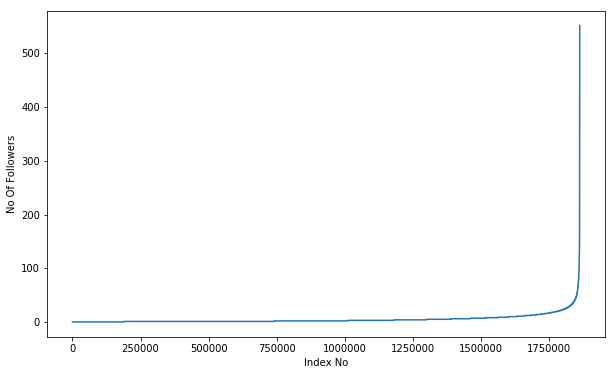

In [10]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

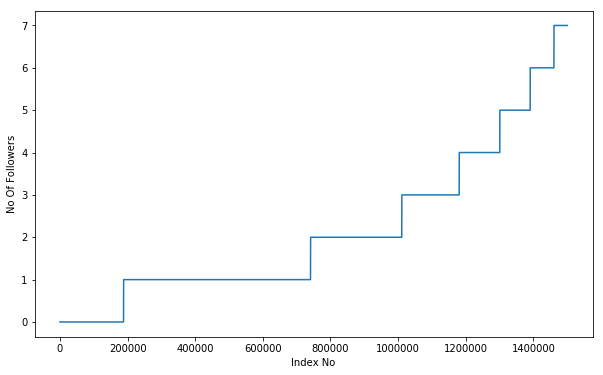

In [11]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

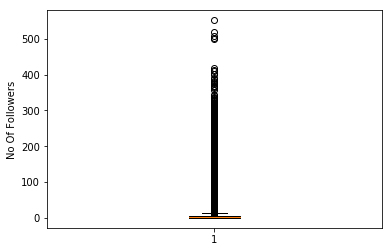

In [12]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [13]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


99% of data having followers of 40 only.

In [14]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


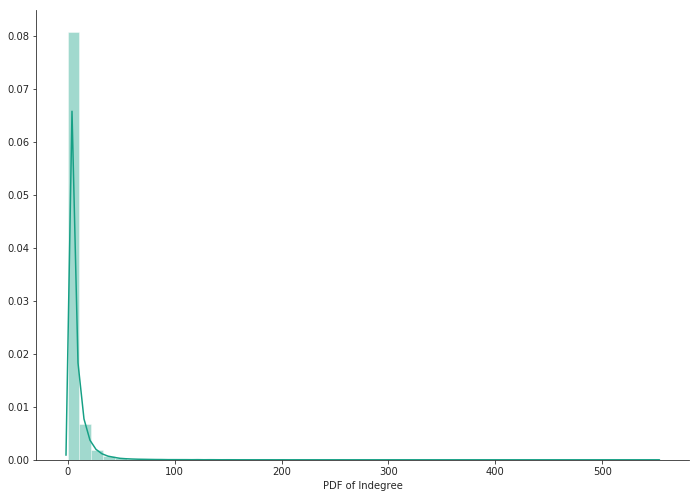

In [15]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()
#plt.show()

##### No of people each person is following

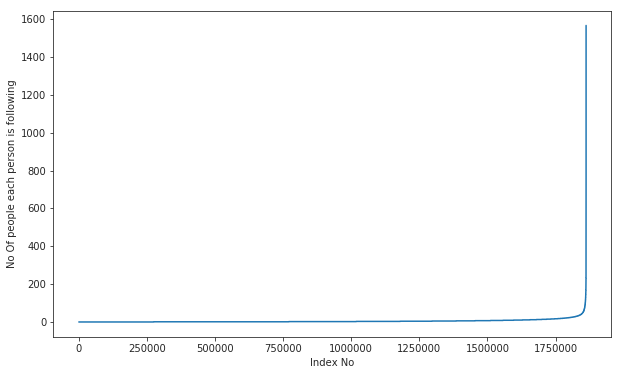

In [16]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

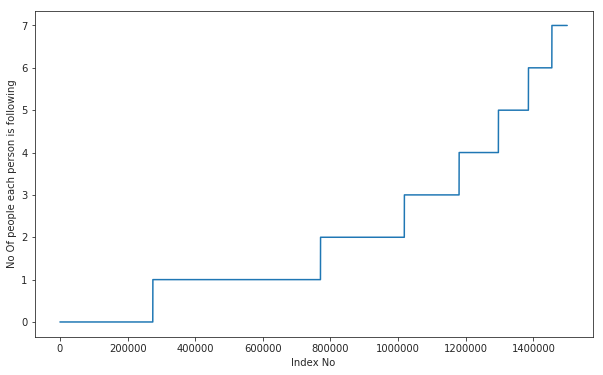

In [17]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

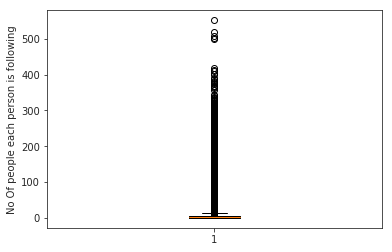

In [18]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [19]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [20]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


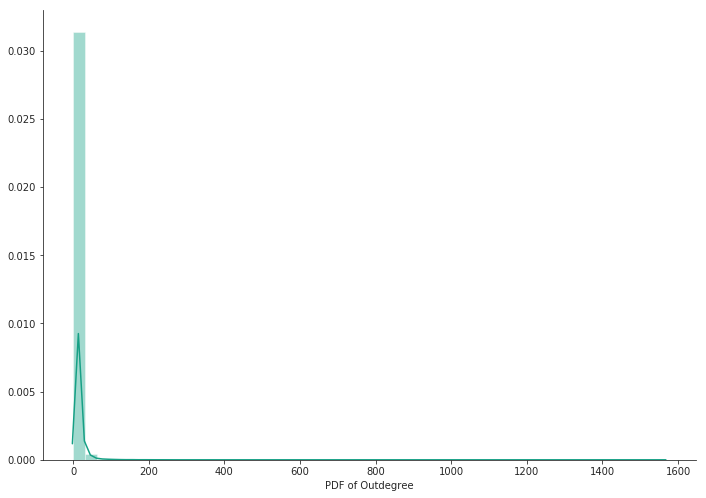

In [21]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [22]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [23]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [24]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


##### both followers + following 

In [25]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

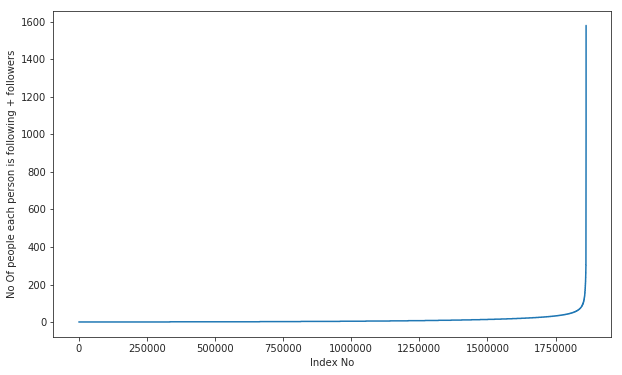

In [26]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

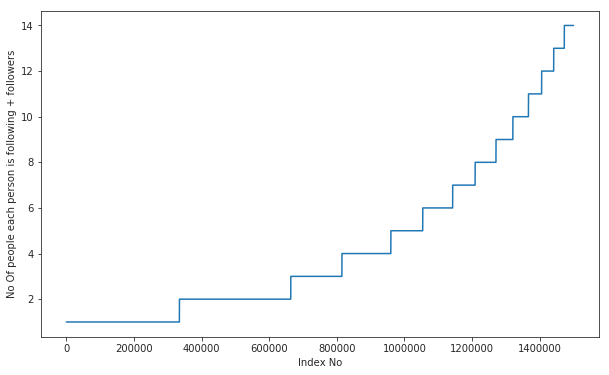

In [27]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [28]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [29]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [30]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [31]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [32]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [33]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


#### Adjacency_matrix   
https://en.wikipedia.org/wiki/Adjacency_matrix

In [5]:
Adj = nx.adjacency_matrix(g,nodelist=sorted(g.nodes()))

In [6]:
Adj = Adj.asfptype()
Adj

<1862220x1862220 sparse matrix of type '<class 'numpy.float64'>'
	with 9437519 stored elements in Compressed Sparse Row format>

## Feature Engineering

### SVD

In [10]:
from scipy.sparse.linalg import svds, eigs
U, s, V = svds(Adj,k = 6)

In [11]:
U

array([[-1.55540638e-14,  1.84913121e-12,  9.16782456e-13,
         1.88607870e-14, -2.53957870e-14, -1.57540975e-16],
       [-1.12760445e-13,  1.25423327e-11,  1.21699839e-11,
         9.70220289e-14, -6.78741222e-13, -1.05714474e-15],
       [-9.96808060e-12,  1.68923622e-11,  1.00421545e-09,
         3.05244303e-10, -5.58126166e-12, -3.72892383e-13],
       ...,
       [-1.49524910e-14,  2.10390639e-12,  3.93555671e-12,
         1.61468941e-13, -8.28056607e-13, -3.32965943e-15],
       [-3.43019958e-12,  1.20274196e-13,  9.65019553e-07,
         6.49192604e-14, -9.94221159e-13, -5.76869029e-13],
       [-3.51042566e-15,  8.67842631e-15,  1.00672793e-13,
         3.89617678e-14, -3.00374684e-15, -2.55704233e-16]])

In [12]:
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

U Shape (1862220, 6)
V Shape (6, 1862220)
s Shape (6,)


### Similarity measures

#### Jaccard Distance:

In [39]:
#for followees
def jaccard_for_followees(a,b):
    if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
        return 0
    sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/\
                                    (len(set(g.successors(a)).union(set(g.successors(b)))))
    return sim

In [40]:
#one test case
jaccard_for_followees(2,1615927)

0.03225806451612903

In [41]:
#for followers
def jaccard_for_followers(a,b):
    if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
        return 0
    sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/\
                                 (len(set(g.predecessors(a)).union(set(g.predecessors(b)))))
    return sim

In [42]:
jaccard_for_followers(2,470294)

0.041666666666666664

#### Cosine distance

In [43]:
#for followees
def cosine_for_followees(a,b):
    if len(set(g.successors(a))) == 0  | len(set(g.successors(b))) == 0:
        return 0
    sim = (len(set(g.successors(a)).intersection(set(g.successors(b)))))/\
                                (math.sqrt(len(set(g.successors(a)))*len((set(g.successors(b))))))
    return sim

In [44]:
cosine_for_followees(2,1615927)

0.08006407690254357

In [45]:
def cosine_for_followers(a,b):
    if len(set(g.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
        return 0
    sim = (len(set(g.predecessors(a)).intersection(set(g.predecessors(b)))))/\
                                 (math.sqrt(len(set(g.predecessors(a))))*(len(set(g.predecessors(b)))))
    return sim

In [46]:
cosine_for_followers(2,470294)

0.023809523809523808

### Ranking Measures

In [47]:
pr = nx.pagerank(g, alpha=0.85)

In [48]:
len(pr)

1862220

In [49]:
##csv reading
df = pd.read_csv('train_woheader.csv', names=['Source', 'Destination'])
df.head()

Source  Destination
0       1       690569
1       1       315892
2       1       189226
3       2       834328
4       2      1615927

In [50]:
#getting all set of edges
r = csv.reader(open('train_woheader.csv','r'))
edges = set()
for edge in r:
    edges.add((edge[0], edge[1]))

#### Generating some edges which are not present in graph for supervised learning

In [51]:
import random
missing_edges = set([])
while (len(missing_edges)<9437519):
    a=random.randint(1, 1862220)
    b=random.randint(1, 1862220)
    if (a,b) not in edges:
        if a!=b:
            missing_edges.add((a,b))
        else:
            continue
    else:
        continue

In [52]:
#printing 10 missing edges
list(missing_edges)[0:10]

[(1293152, 1800897),
 (420967, 1072419),
 (970737, 1444392),
 (1853675, 1452068),
 (507506, 1474755),
 (1186502, 1835133),
 (1659674, 90875),
 (1857255, 507654),
 (1434433, 1418683),
 (328834, 579284)]

In [53]:
#checking in graph
g.has_edge(446240, 834358)

False

In [54]:
df_neg = pd.DataFrame(list(missing_edges), columns=['Source', 'Destination'])

In [55]:
df_neg.head()

Source  Destination
0  1293152      1800897
1   420967      1072419
2   970737      1444392
3  1853675      1452068
4   507506      1474755

In [56]:
#concatinating both 
final=df.append(df_neg)

In [57]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18875038 entries, 0 to 9437518
Data columns (total 2 columns):
Source         int64
Destination    int64
dtypes: int64(2)
memory usage: 432.0 MB


In [58]:
final.shape

(18875038, 2)

In [15]:
listofones = [1] * 9437519
listofzeroes = [0]* 9437519
listofones.extend(listofzeroes)

#### Shortest path:

In [60]:
#if has direct edge then deleting that edge and calculating sgotest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if g.has_edge(a,b):
            g.remove_edge(a,b)
            p= len(nx.shortest_path(g,source=a,target=b))-1
            g.add_edge(a,b)
        else:
            p= len(nx.shortest_path(g,source=a,target=b))-1
        return p
    except:
        return -1

In [61]:
#testing
compute_shortest_path_length(77697, 826021)

10

#### Checking for same community

In [62]:
wcc=list(nx.weakly_connected_components(g))
def belongs_to_same_wcc(a,b):
    index = []
    if g.has_edge(b,a):
        return 1
    if g.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                g.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    g.add_edge(a,b)
                    return 0
                else:
                    g.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [63]:
belongs_to_same_wcc(861, 1659750)

0

#### Adamic/Adar Index

In [64]:
def calc_adar_in(a,b):
    sum=0
    n=list(set(g.successors(a)).intersection(set(g.successors(b))))
    if len(n)!=0:
        for i in n:
            sum=sum+(1/np.log10(len(list(g.predecessors(i)))))
        return sum
    else:
        return 0

In [65]:
calc_adar_in(1,189226)

0.6838083759938891

#### Is persion was following back:

In [66]:
def follows_back(a,b):
    if g.has_edge(b,a):
        return 1
    else:
        return 0

In [68]:
follows_back(1,189226)

1

#### Katz Centrality:

In [12]:
katz = nx.katz.katz_centrality(g,alpha=0.005,beta=1)
#import pickle
#katz = pickle.load(open('katz.p','rb'))

In [15]:
len(katz)

1862220

#### Hits Score

In [16]:
hits = nx.hits(g, max_iter=100, tol=1e-08, nstart=None, normalized=True)
#hits = pickle.load(open('hits.p','rb'))

In [17]:
len(hits)

2

In [18]:
len(hits[0])

1862220

##### From all above scores preparing data set 

In [69]:
f1=[]
f2=[]
for i in range(9437519*2):
    f1.append(jaccard_for_followers((final['Source'].values)[i],(final['Destination'].values)[i]))
    f2.append(jaccard_for_followees((final['Source'].values)[i],(final['Destination'].values)[i]))

In [70]:
final['jaccard_for_followers']=f1
final['jaccard_for_followees']=f2

In [71]:
num_followers_s=[]
num_followees_s=[]
num_followers_d=[]
num_followees_d=[]
inter_followers=[]
inter_followees=[]
for i in range(9437519*2):
    s1=set(g.predecessors((final['Source'].values)[i]))
    d1=set(g.predecessors((final['Destination'].values)[i]))
    
    s2=set(g.successors((final['Source'].values)[i]))
    d2=set(g.successors((final['Destination'].values)[i]))
    
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))
    
    inter_followers.append(len(s1.intersection(d1)))
    inter_followees.append(len(s2.intersection(d2)))

In [72]:
final['num_followers_s']=num_followers_s
final['num_followees_s']=num_followees_s
final['num_followers_d']=num_followers_d
final['num_followees_d']=num_followees_d

In [73]:
final['inter_followers']=inter_followers
final['inter_followees']=inter_followees

In [74]:
final.head(5)

Source  Destination  jaccard_for_followers  jaccard_for_followees  \
0       1       690569               0.066667               0.090909   
1       1       315892               0.033333               0.029412   
2       1       189226               0.200000               0.166667   
3       2       834328               0.000000               0.000000   
4       2      1615927               0.025641               0.032258   

   num_followers_s  num_followees_s  num_followers_d  num_followees_d  \
0                3                3               29               21   
1                3                3               28               32   
2                3                3                3                4   
3                4                6               71               62   
4                4                6               36               26   

   inter_followers  inter_followees  
0                2                2  
1                1                1  
2                1                1  
3                0                0  
4                1                1

In [75]:
adar=[]
for i in range(9437519*2):
    adar.append(calc_adar_in((final['Source'].values)[i],(final['Destination'].values)[i]))

In [76]:
back=[]
for i in range(9437519*2):
    back.append(follows_back((final['Source'].values)[i],(final['Destination'].values)[i]))

In [ ]:
same_comp=[]
for i in range(9437519*2):
    same_comp.append(belongs_to_same_wcc((final['Source'].values)[i],(final['Destination'].values)[i]))

In [ ]:
path=[]
for i in range(9437519*2):
    path.append(compute_shortest_path_length((final['Source'].values)[i],(final['Destination'].values)[i]))

In [ ]:
pr_s=[]
pr_d=[]
for i in range(9437519*2):
    pr_s.append(pr.get((final['Source'].values)[i]))
    pr_d.append(pr.get((final['Destination'].values)[i]))

In [ ]:
pr_s=[]
pr_d=[]
for i in range(9437519*2):
    pr_s.append(pr.get((final['Source'].values)[i]))
    pr_d.append(pr.get((final['Destination'].values)[i]))

In [117]:
final['adar_index']=adar
final['follows_back']=back
final['shortest_path']=path
final['page_rank_s']= pr_s
final['page_rank_d']= pr_d
final['same_comp']=same_comp

In [23]:
final['katz_s'] = final.Source.apply(lambda x: katz[x])
final['katz_d'] = final.Destination.apply(lambda x: katz[x])

In [28]:
final['hubs_s'] = final.Source.apply(lambda x: hits[0][x])
final['hubs_d'] = final.Destination.apply(lambda x: hits[0][x])
final['authorities_s'] = final.Source.apply(lambda x: hits[1][x])
final['authorities_d'] = final.Destination.apply(lambda x: hits[1][x])

In [29]:
from pandas import HDFStore,DataFrame
hdf = HDFStore('storage_temp.h5')

In [30]:
hdf.put('df',final, format='table', data_columns=True)

In [14]:
from pandas import read_hdf
hdf = read_hdf('storage_temp.h5', 'df',mode='r')

In [15]:
hdf.head()

Source  Destination  jaccard_for_followers  jaccard_for_followees  \
0       1       690569               0.066667               0.090909   
1       1       315892               0.033333               0.029412   
2       1       189226               0.200000               0.166667   
3       2       834328               0.000000               0.000000   
4       2      1615927               0.025641               0.032258   

   num_followers_s  num_followees_s  num_followers_d  num_followees_d  \
0                3                3               29               21   
1                3                3               28               32   
2                3                3                3                4   
3                4                6               71               62   
4                4                6               36               26   

   inter_followers  inter_followees      ...        shortest_path  \
0                2                2      ...                    2   
1                1                1      ...                    2   
2                1                1      ...                    2   
3                0                0      ...                    4   
4                1                1      ...                    2   

    page_rank_s   page_rank_d  same_comp    katz_s    katz_d        hubs_s  \
0  2.979445e-07  3.726469e-06          1  0.000722  0.000819  8.549204e-18   
1  2.979445e-07  2.420463e-06          1  0.000722  0.000815  8.549204e-18   
2  2.979445e-07  5.499399e-07          1  0.000722  0.000721  8.549204e-18   
3  2.305481e-07  3.609568e-06          1  0.000727  0.000987  5.733354e-17   
4  2.305481e-07  3.146838e-06          1  0.000727  0.000849  5.733354e-17   

         hubs_d  authorities_s  authorities_d  
0  1.690629e-16   3.812313e-18   3.942264e-16  
1  3.756260e-16   3.812313e-18   1.088839e-15  
2  1.311680e-16   3.812313e-18   1.031571e-18  
3  2.201178e-15   1.470085e-17   7.312979e-15  
4  2.568950e-16   1.470085e-17   1.377441e-15  

[5 rows x 22 columns]

In [13]:
del Adj

In [17]:
svd_u_s=[]
svd_u_d=[]
svd_v_s=[]
svd_v_d=[]
for i in range(9437519*2):
    svd_u_s.append(U[(hdf['Source'].values)[i]-1])
    svd_u_d.append(U[(hdf['Destination'].values)[i]-1])
    svd_v_s.append(V.T[(hdf['Source'].values)[i]-1])
    svd_v_d.append(V.T[(hdf['Destination'].values)[i]-1])

In [19]:
def get_svd_frame(svd_para,s_para):
    hdf['svd_'+svd_para+'_'+s_para+'_1']=df_s_u['svd_u_s_1']
    del df_s_u['svd_u_s_1']
    hdf['svd_'+svd_para+'_'+s_para+'_2']=df_s_u['svd_u_s_2']
    del df_s_u['svd_u_s_2']
    hdf['svd_'+svd_para+'_'+s_para+'_3']=df_s_u['svd_u_s_3']
    del df_s_u['svd_u_s_3']
    hdf['svd_'+svd_para+'_'+s_para+'_4']=df_s_u['svd_u_s_4']
    del df_s_u['svd_u_s_4']
    hdf['svd_'+svd_para+'_'+s_para+'_5']=df_s_u['svd_u_s_5']
    del df_s_u['svd_u_s_5']
    hdf['svd_'+svd_para+'_'+s_para+'_6']=df_s_u['svd_u_s_6']
    del df_s_u['svd_u_s_6']

In [20]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 
                                      'svd_u_s_6'], data=svd_u_s)

In [21]:
get_svd_frame('u','s')
del svd_u_s
del df_s_u

In [22]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 
                                 'svd_u_s_6'], data=svd_v_s)

In [23]:
get_svd_frame('v','s')
del svd_v_s
del df_s_u

In [24]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6'], data=svd_u_d)

In [25]:
get_svd_frame('u','d')
del svd_u_d
del df_s_u

In [26]:
df_s_u = pd.DataFrame(columns=['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4','svd_u_s_5', 'svd_u_s_6'], data=svd_v_d)

In [27]:
get_svd_frame('v','d')
del svd_v_d
del df_s_u

In [29]:
hdf.head()

Source  Destination  jaccard_for_followers  jaccard_for_followees  \
0       1       690569               0.066667               0.090909   
1       1       315892               0.033333               0.029412   
2       1       189226               0.200000               0.166667   
3       2       834328               0.000000               0.000000   
4       2      1615927               0.025641               0.032258   

   num_followers_s  num_followees_s  num_followers_d  num_followees_d  \
0                3                3               29               21   
1                3                3               28               32   
2                3                3                3                4   
3                4                6               71               62   
4                4                6               36               26   

   inter_followers  inter_followees      ...          svd_u_d_3     svd_u_d_4  \
0                2                2      ...       7.574563e-11  2.203385e-13   
1                1                1      ...       7.789290e-11  2.007310e-12   
2                1                1      ...       6.202886e-13  3.541983e-15   
3                0                0      ...       3.660370e-09  1.281799e-11   
4                1                1      ...       3.016396e-11  7.628502e-12   

      svd_u_d_5     svd_u_d_6     svd_v_d_1     svd_v_d_2     svd_v_d_3  \
0 -1.137448e-12 -3.117460e-15 -1.192614e-12  1.769739e-11  7.610923e-11   
1 -1.052990e-11 -6.926059e-15 -6.693973e-13  1.119150e-10  4.106460e-11   
2 -4.075645e-14 -2.418571e-15 -5.133729e-14  1.009115e-10  5.980483e-13   
3 -3.699026e-11 -4.058605e-14 -8.897765e-12  1.398199e-09  1.295040e-09   
4 -8.342092e-12 -4.736594e-15 -2.254699e-12  4.046084e-11  1.085944e-10   

      svd_v_d_4     svd_v_d_5     svd_v_d_6  
0  2.991776e-13 -2.859740e-12 -7.345663e-15  
1  2.169967e-12 -1.106141e-12 -2.028846e-14  
2  2.168489e-15 -7.963057e-15 -1.922222e-17  
3  7.927656e-12 -9.188607e-11 -1.362635e-13  
4  7.773768e-13 -3.284524e-12 -2.566603e-14  

[5 rows x 46 columns]

Storing data in HDF format

In [28]:
from pandas import HDFStore,DataFrame
hdf1 = HDFStore('storage_final.h5')

In [30]:
hdf1.put('df1',hdf, format='table', data_columns=True)

In [2]:
from pandas import read_hdf
hdf = read_hdf('storage_final.h5', 'df1',mode='r')

In [3]:
hdf.columns

Index(['Source', 'Destination', 'jaccard_for_followers',
       'jaccard_for_followees', 'num_followers_s', 'num_followees_s',
       'num_followers_d', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'shortest_path',
       'page_rank_s', 'page_rank_d', 'same_comp', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [16]:
len(listofones)

18875038

##### Train Test split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hdf,listofones,stratify=listofones,test_size=0.10,random_state=13)

In [18]:
print('Train Shape',X_train.shape)
print('Test Shape',X_test.shape)

Train Shape (16987534, 46)
Test Shape (1887504, 46)


### Machine learning Models

Estimators =  10 Train Score 0.9355605557726946 test Score 0.9358778299053476
Estimators =  50 Train Score 0.9324250741464069 test Score 0.9327588195256303
Estimators =  100 Train Score 0.9360400602184306 test Score 0.9363720826582735
Estimators =  250 Train Score 0.9326616802528905 test Score 0.9330067584941765
Estimators =  450 Train Score 0.9356461169461268 test Score 0.9360057114029872


Text(0.5,1,'Estimators vs score at depth of 5')

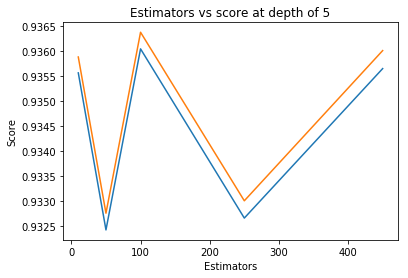

In [8]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train))
    test_sc = f1_score(y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

Depth =  3 Train Score 0.9135633952211895 test Score 0.9138565572544209
Depth =  5 Train Score 0.9357882996440469 test Score 0.9361266342454293
Depth =  7 Train Score 0.9435873122599637 test Score 0.943848372935684
Depth =  9 Train Score 0.9468496272790211 test Score 0.94706832113918
Depth =  11 Train Score 0.954207176045251 test Score 0.9543986099916757
Depth =  13 Train Score 0.9576369816149864 test Score 0.9576574235211681
Depth =  15 Train Score 0.9643837384370765 test Score 0.9643493093625056


Text(0.5,1,'Depth vs score at depth of 5 at estimators = 110')

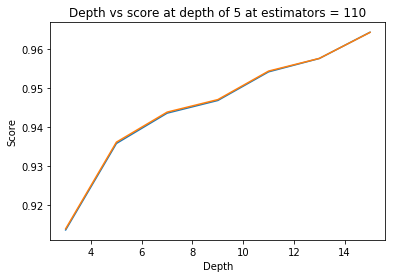

In [12]:
depths = [3,5,7,9,11,13,15]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train))
    test_sc = f1_score(y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 110')

Depth =  15 Train Score 0.9643837384370765 test Score 0.9643493093625056
Depth =  17 Train Score 0.9684922617199279 test Score 0.9684519418634415
Depth =  19 Train Score 0.969924351511325 test Score 0.9699622974598553
Depth =  25 Train Score 0.972800920649682 test Score 0.9727983990794277
Depth =  30 Train Score 0.973176868239819 test Score 0.973154358820791
Depth =  50 Train Score 0.9732532862836132 test Score 0.9731564649237942


Text(0.5,1,'Estimators vs score')

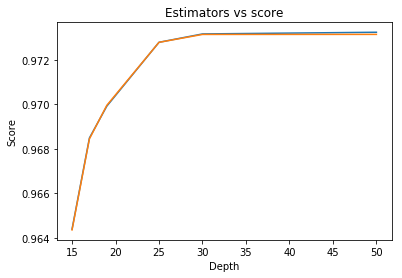

In [14]:
depths = [15,17,19,25,30,50]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    train_sc = f1_score(y_train,clf.predict(X_train))
    test_sc = f1_score(y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Estimators vs score')

Depth =  30 Train Score 0.973176868239819 test Score 0.973154358820791
Depth =  50 Train Score 0.9732532862836132 test Score 0.9731564649237942
Depth =  60 Train Score 0.973267182073576 test Score 0.9731879925133946
Depth =  75 Train Score 0.973267182073576 test Score 0.9731879925133946
Depth =  95 Train Score 0.973267182073576 test Score 0.9731879925133946
Depth =  120 Train Score 0.973267182073576 test Score 0.9731879925133946
Depth =  150 Train Score 0.973267182073576 test Score 0.9731879925133946
Depth =  190 Train Score 0.973267182073576 test Score 0.9731879925133946


Text(0.5,1,'Depth vs score ')

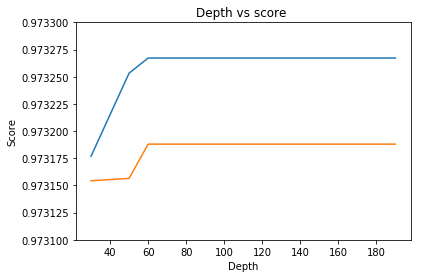

In [12]:
%matplotlib inline
depths = [30,50,60,75,95,120,150,190]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train))
    test_sc = f1_score(y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.ylim(0.9731,0.9733)
plt.title('Depth vs score ')

In [9]:
train_scores = []
test_scores = []
from sklearn.model_selection import ParameterGrid
param_grid = {'min_sample_leafs': [30,50,70,90],'min_samples_splits': [60,100,125,150,180]}
for i in list(ParameterGrid(param_grid)):
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=i['min_sample_leafs'], min_samples_split=i['min_samples_splits'],
            min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train,y_train)
    train_sc = f1_score(y_train,clf.predict(X_train))
    test_sc = f1_score(y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('min_samples_leaf=',i['min_sample_leafs'],'min_samples_split=',i['min_samples_splits'],'Train Score',train_sc,'test Score',test_sc)

min_samples_leaf= 30 min_samples_split= 60 Train Score 0.9738156889595279 test Score 0.97370504280618
min_samples_leaf= 30 min_samples_split= 100 Train Score 0.9737577189170793 test Score 0.973658141861029
min_samples_leaf= 30 min_samples_split= 125 Train Score 0.9737928509172361 test Score 0.9737455680591954
min_samples_leaf= 30 min_samples_split= 150 Train Score 0.9737628940150641 test Score 0.9737056919525169
min_samples_leaf= 30 min_samples_split= 180 Train Score 0.973706280130253 test Score 0.9736490120988784
min_samples_leaf= 50 min_samples_split= 60 Train Score 0.9733467047234561 test Score 0.9733382151892095
min_samples_leaf= 50 min_samples_split= 100 Train Score 0.9733467047234561 test Score 0.9733382151892095
min_samples_leaf= 50 min_samples_split= 125 Train Score 0.9732031760503617 test Score 0.9731303287498254
min_samples_leaf= 50 min_samples_split= 150 Train Score 0.9733574333569979 test Score 0.973313655680691
min_samples_leaf= 50 min_samples_split= 180 Train Score 0.9732

In [9]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(50,75),
              "min_samples_split": sp_randint(120,190),
              "min_samples_leaf": sp_randint(25,65)}
clf = RandomForestClassifier(random_state=25,n_jobs=-1)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)
rf_random.fit(X_train,y_train)

import pickle
pickle.dump(rf_random,open('rf_random_2.p','wb'))

In [10]:
rf_random.grid_scores_

[mean: 0.97308, std: 0.00012, params: {'max_depth': 54, 'min_samples_leaf': 51, 'min_samples_split': 135, 'n_estimators': 117},
 mean: 0.97342, std: 0.00017, params: {'max_depth': 68, 'min_samples_leaf': 33, 'min_samples_split': 148, 'n_estimators': 109},
 mean: 0.97351, std: 0.00018, params: {'max_depth': 70, 'min_samples_leaf': 30, 'min_samples_split': 121, 'n_estimators': 112},
 mean: 0.97304, std: 0.00019, params: {'max_depth': 53, 'min_samples_leaf': 49, 'min_samples_split': 175, 'n_estimators': 108},
 mean: 0.97356, std: 0.00018, params: {'max_depth': 70, 'min_samples_leaf': 28, 'min_samples_split': 121, 'n_estimators': 121}]

In [14]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97307626 0.97342125 0.97350956 0.97303721 0.97355554]
mean train scores [0.9732093  0.9735835  0.97369909 0.97316352 0.97375194]


In [8]:
clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=121,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
clf_rf.fit(X_train,y_train)
import pickle
pickle.dump(clf_rf,open('clf_rf.p','wb'))

In [12]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


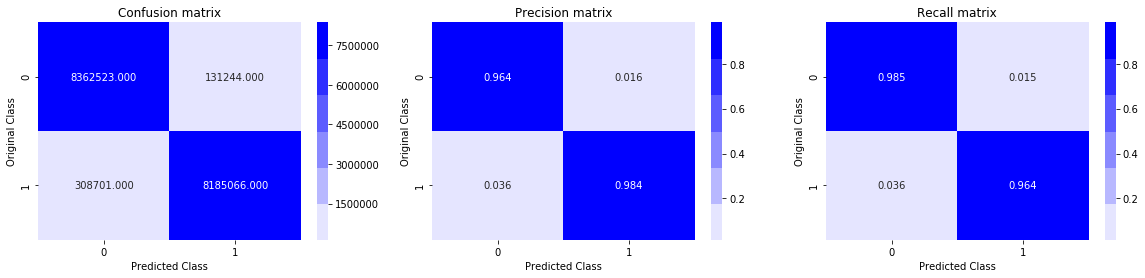

Test confusion_matrix


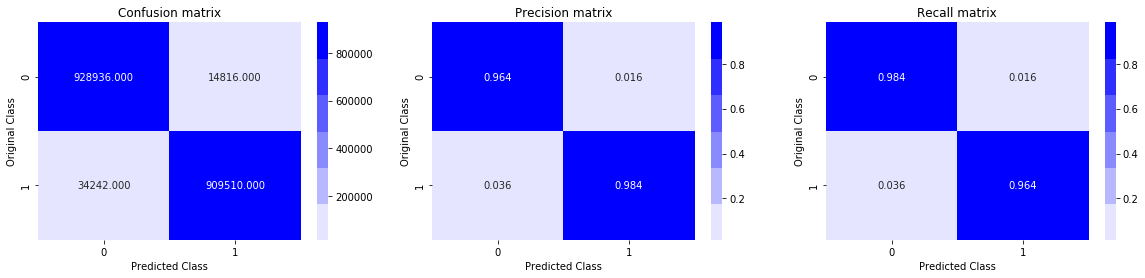

In [16]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,clf_rf.predict(X_train))
print('Test confusion_matrix')
plot_confusion_matrix(y_test,clf_rf.predict(X_test))

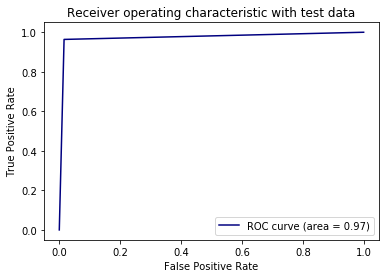

In [23]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,clf_rf.predict(X_test))
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

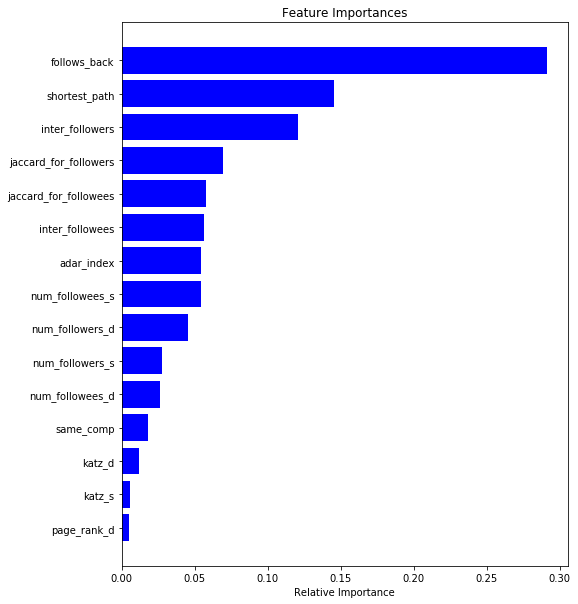

In [36]:
features = X_train.columns
importances = clf_rf.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(8,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Some other features: 

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network. Chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. credit - Quora

In [7]:
#weight for source and destination of each link
Weight_in = []
Weight_out = []
for i in g.nodes():
    s1=set(g.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    s2=set(g.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_in.append((i,w_in))
    Weight_out.append((i,w_out))

In [10]:
#converting as dict to map DataFrame
Weight_in_dict = dict(Weight_in)
Weight_out_dict = dict(Weight_out)

In [12]:
#saving to disk
import pickle
Weight_in_dict = pickle.load(open('Weight_in_dict.p','rb'))
Weight_out_dict = pickle.load(open('Weight_out_dict.p','rb'))

In [13]:
#mapping to pandas
hdf['Weight_in'] = hdf.Destination.apply(lambda x: Weight_in_dict[x])
hdf['Weight_out'] = hdf.Source.apply(lambda x: Weight_out_dict[x])

In [14]:
#some features engineerings on tose in and out weigts
hdf['Weight_f1'] = hdf.Weight_in + hdf.Weight_out
hdf['Weight_f2'] = hdf.Weight_in * hdf.Weight_out
hdf['Weight_f3'] = (2*hdf.Weight_in + 1*hdf.Weight_out)
hdf['Weight_f4'] = (1*hdf.Weight_in + 2*hdf.Weight_out)

In [15]:
hdf.columns

Index(['Source', 'Destination', 'jaccard_for_followers',
       'jaccard_for_followees', 'num_followers_s', 'num_followees_s',
       'num_followers_d', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'shortest_path',
       'page_rank_s', 'page_rank_d', 'same_comp', 'katz_s', 'katz_d', 'hubs_s',
       'hubs_d', 'authorities_s', 'authorities_d', 'svd_u_s_1', 'svd_u_s_2',
       'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6', 'svd_v_s_1',
       'svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',
       'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5',
       'svd_u_d_6', 'svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4',
       'svd_v_d_5', 'svd_v_d_6', 'Weight_in', 'Weight_out', 'Weight_f1',
       'Weight_f2', 'Weight_f3', 'Weight_f4'],
      dtype='object')

#### Some Other SVD Features:

In [7]:
### svd decomposition
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd_mat = svd.fit_transform(Adj)

In [8]:
#nodes list sorted
nodes_list = list(g.nodes())
nodes_list = sorted(nodes_list)
#node and index as key value pairs, i need it because getting index from list is O(n) order
# but from dict its O(1)
nodes_list_dict = {k:v for v,k in enumerate(nodes_list)}

In [12]:
# deleting because of sapce constraint
del Adj
del g
del nodes_list

In [13]:
import pickle
pickle.dump(svd_mat,open('svd_map.p','wb'))
pickle.dump(nodes_list_dict,open('nodes_list_dict.p','wb'))

In [5]:
import pickle
svd_mat = pickle.load(open('svd_map.p','rb'))
nodes_list_dict = pickle.load(open('nodes_list_dict.p','rb'))

In [8]:
### SVD dot product of source and destination vectores
### SVD mean of source and destination vector
from tqdm import tqdm
svd_dot = []
svd_mean_dest = []
svd_mean_source = []
for idx,temp_series in tqdm(hdf.iterrows(),total=hdf.shape[0]):
    in_idx = nodes_list_dict[temp_series.Destination]
    out_idx = nodes_list_dict[temp_series.Source]
    svd_temp = np.dot(svd_mat[in_idx,:],svd_mat[out_idx,:])
    svd_dot.append(svd_temp)
    svd_mean_dest.append(np.squeeze(np.mean(svd_mat[in_idx,:])))
    svd_mean_source.append(np.squeeze(np.mean(svd_mat[out_idx,:])))

100%|██████████| 18875038/18875038 [19:26<00:00, 16183.87it/s]


In [9]:
import pickle
pickle.dump(svd_dot,open('svd_dot.p','wb'))
pickle.dump(svd_mean_source,open('svd_mean_source.p','wb'))
pickle.dump(svd_mean_dest,open('svd_mean_dest.p','wb'))

In [16]:
###mappng above features into 
hdf['svd_dot'] = svd_dot
hdf['svd_mean_s'] = svd_mean_source
hdf['svd_mean_d'] = svd_mean_dest
hdf['log_svd_sd'] = np.log(svd_mean_source) + np.log(svd_mean_dest)

In [21]:
from pandas import HDFStore,DataFrame
hdf2 = HDFStore('storage_all_features.h5')

In [22]:
#saving to disk 
hdf2.put('df1',hdf, format='table', data_columns=True)

In [23]:
hdf2.close()

In [2]:
## reading and deleting some columns
from pandas import read_hdf
hdf = read_hdf('storage_all_features.h5', 'df1',mode='r')
hdf.drop(['Source','Destination','log_svd_sd'],axis=1,inplace=True)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hdf,listofones,stratify=listofones,test_size=0.10,random_state=13)

In [5]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
param_dist = {"n_estimators":sp_randint(105,135),
              "max_depth": sp_randint(50,75),
              "min_samples_split": sp_randint(120,190),
              "min_samples_leaf": sp_randint(25,65)}
clf = RandomForestClassifier(max_features=11,random_state=25,n_jobs=-1)
rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=6,cv=10,scoring='f1',random_state=25)
rf_random.fit(X_train,y_train)

pickle.dump(rf_random,open('rf_random_final.p','wb'))

In [6]:
clf_random.grid_scores_

[mean: 0.97631, std: 0.00013, params: {'max_depth': 54, 'min_samples_leaf': 51, 'min_samples_split': 135, 'n_estimators': 134},
 mean: 0.97629, std: 0.00013, params: {'max_depth': 72, 'min_samples_leaf': 48, 'min_samples_split': 164, 'n_estimators': 123},
 mean: 0.97631, std: 0.00012, params: {'max_depth': 58, 'min_samples_leaf': 53, 'min_samples_split': 124, 'n_estimators': 130},
 mean: 0.97671, std: 0.00014, params: {'max_depth': 70, 'min_samples_leaf': 30, 'min_samples_split': 121, 'n_estimators': 112},
 mean: 0.97624, std: 0.00013, params: {'max_depth': 53, 'min_samples_leaf': 49, 'min_samples_split': 175, 'n_estimators': 108},
 mean: 0.97676, std: 0.00013, params: {'max_depth': 70, 'min_samples_leaf': 28, 'min_samples_split': 121, 'n_estimators': 127}]

In [7]:
print('mean test scores',clf_random.cv_results_['mean_test_score'])
print('mean train scores',clf_random.cv_results_['mean_train_score'])

mean test scores [0.9763108  0.97628636 0.97630894 0.97671344 0.97624188 0.97675791]
mean train scores [0.97689315 0.9768383  0.97689703 0.97746001 0.97676634 0.97751521]


In [6]:
clf_final = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=121,
            min_weight_fraction_leaf=0.0, n_estimators=127, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
clf_final.fit(X_train,y_train)
clf_final

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=70, max_features=11, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=121,
            min_weight_fraction_leaf=0.0, n_estimators=127, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [7]:
y_pred_train = clf_final.predict(X_train)
y_pred_test = clf_final.predict(X_test)

In [9]:
print('Train f1 score',f1_score(y_train,y_pred_train))
print('Test f1 score',f1_score(y_test,y_pred_test))

Train f1 score 0.9775433278866003
Test f1 score 0.9768795144676669


Train confusion_matrix


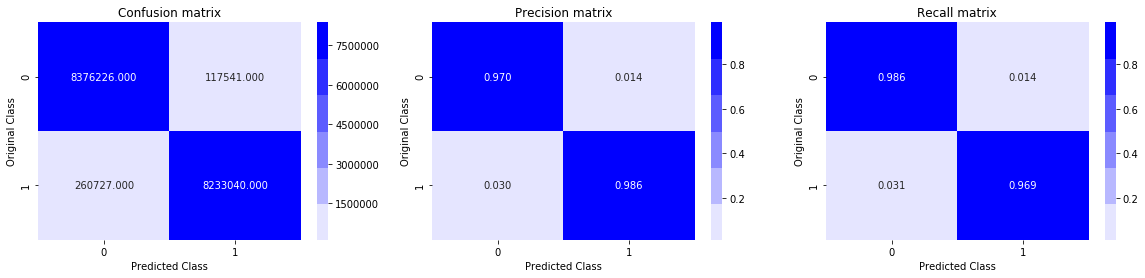

Test confusion_matrix


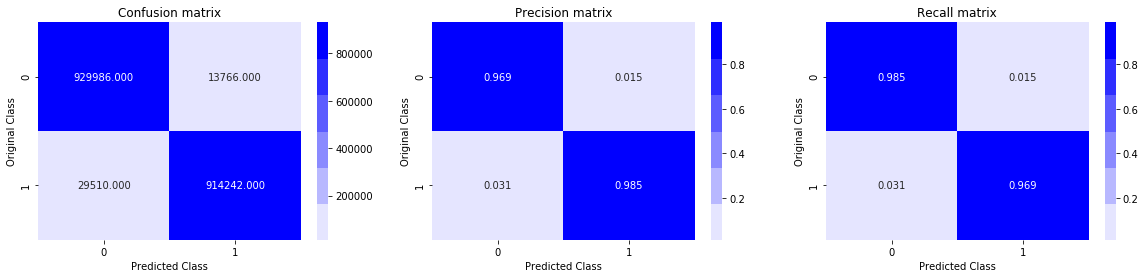

In [13]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_pred_train)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_pred_test)

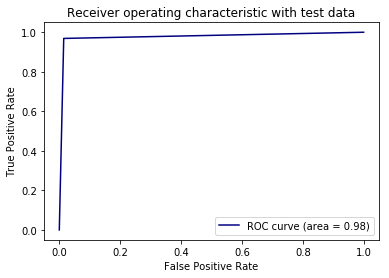

In [15]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_pred_test)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

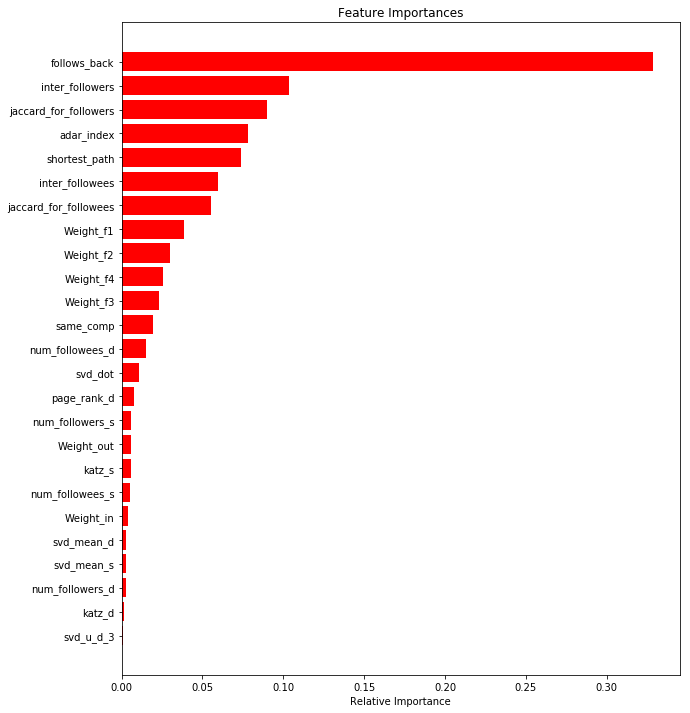

In [19]:
features = X_train.columns
importances = clf_final.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

improved some score and we can observe that Weight features and svd dot produts is somewhat better features than so many features. 

In [18]:
feature_importances = pd.DataFrame(clf_final.feature_importances_,index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

importance
follows_back             0.328643
inter_followers          0.103482
jaccard_for_followers    0.090029
adar_index               0.077946
shortest_path            0.073936
inter_followees          0.059496
jaccard_for_followees    0.055198
Weight_f1                0.038678
Weight_f2                0.029778
Weight_f4                0.025750
Weight_f3                0.023308
same_comp                0.019615
num_followees_d          0.014875
svd_dot                  0.010756
page_rank_d              0.007481
num_followers_s          0.005751
Weight_out               0.005657
katz_s                   0.005565
num_followees_s          0.005110
Weight_in                0.003990
svd_mean_d               0.002942
svd_mean_s               0.002532
num_followers_d          0.002524
katz_d                   0.001633
svd_u_d_3                0.001161
svd_v_d_3                0.001138
svd_u_s_3                0.001052
svd_v_s_3                0.001019
page_rank_s              0.000272
svd_u_s_6                0.000167
svd_v_d_6                0.000159
svd_v_s_6                0.000135
svd_u_d_6                0.000059
svd_v_d_2                0.000054
svd_v_s_2                0.000047
svd_u_s_2                0.000027
svd_u_d_2                0.000022
hubs_s                   0.000006
authorities_s            0.000004
authorities_d            0.000004
hubs_d                   0.000002